In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(45)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device: ", device)

Device:  cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
dataset = torchvision.datasets.FashionMNIST(
    root='.', download=True, train=True, transform=transform)

100%|██████████| 26421880/26421880 [00:13<00:00, 1947761.82it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 150808.81it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2800985.30it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22562462.90it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
batch_size = 32

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True
)

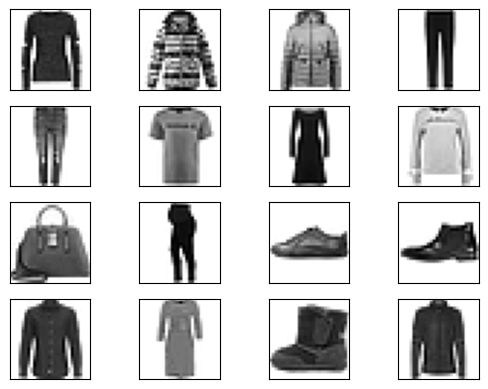

In [ ]:
data, labels = next(iter(data_loader))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(data[i].reshape(28, 28), cmap="gray_r")
  plt.xticks([])
  plt.yticks([])

In [ ]:
# Discriminator Model

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(784, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(x.size(0), 784)
    output = self.model(x)
    return output

In [ ]:
# Generator Model

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 784),
        nn.Tanh(),
    )

  def forward(self, x):
    output = self.model(x)
    output = output.view(x.size(0), 1, 28, 28)
    return output

In [ ]:
def train(n_epochs, train_loader, batch_size, dis, gen, loss, dis_optim, gen_optim):

  for epoch in range(n_epochs):
    for n, (real_data, labels) in enumerate(train_loader):

      # Real FashionMNIST Data
      real_data = real_data.to(device)
      real_data_labels = torch.ones((batch_size, 1)).to(device) # All real data labeled 1

      # Generated Data:
      noise = torch.randn((batch_size, 100)).to(device)
      gen_data = gen(noise)
      gen_data_labels = torch.zeros((batch_size, 1)).to(device)

      # Combine Real and Gen Data
      combineed_data = torch.cat((real_data, gen_data))
      combined_labels = torch.cat((real_data_labels, gen_data_labels))

      # Discrimainator Training
      dis.zero_grad()
      dis_out = dis(combineed_data)
      dis_loss = loss(dis_out, combined_labels)
      dis_loss.backward()
      dis_optim.step()

      # Generator Training
      gen.zero_grad()
      noise = torch.randn((batch_size, 100)).to(device)
      dis_out = dis(gen(noise))
      gen_loss = loss(dis_out, real_data_labels)
      gen_loss.backward()
      gen_optim.step()

    if epoch%10==0:
      print(f"Epoch: {epoch} Loss D.: {dis_loss}, Loss G.: {gen_loss}")

In [ ]:
dis = Discriminator().to(device)
gen = Generator().to(device)

In [ ]:
lr = 0.0002
n_epochs =50
loss = nn.BCELoss()

dis_optim = torch.optim.Adam(dis.parameters(), lr=lr)
gen_optim = torch.optim.Adam(gen.parameters(), lr=lr)

In [ ]:
train(n_epochs, data_loader, batch_size, dis, gen, loss, dis_optim, gen_optim)

Epoch: 0 Loss D.: 0.6554511785507202, Loss G.: 0.9702532291412354
Epoch: 10 Loss D.: 0.6210367679595947, Loss G.: 0.7340444326400757
Epoch: 20 Loss D.: 0.7008724212646484, Loss G.: 0.7672232985496521
Epoch: 30 Loss D.: 0.6068747043609619, Loss G.: 0.7915489673614502
Epoch: 40 Loss D.: 0.5858137607574463, Loss G.: 0.8486073613166809


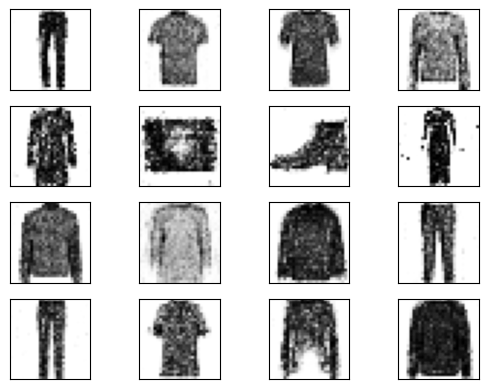

In [ ]:
noise = torch.randn(batch_size, 100).to(device=device)
gen_data = gen(noise)

gen_data = gen_data.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(gen_data[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])